In [5]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
import fbprophet


def XGBForecasterRMSE(df,frequency = 'hourly'):
    if frequency == 'hourly':
        df['date'] = pd.to_datetime(df['date'],format='%d-%m-%Y %H:%M')
        df4 = df.copy()
        df4 = create_features_hourly(df)
        df4 = df.set_index('date')
        df4.sort_values('date',inplace=True)
    #     print(df4.info())
        df4["value"] = df4["value"].fillna(value=df4["value"].mean())
    #     print(df4.info())
    #     print(df4.head())
        X, y = df4.loc[:,['temperature','var1','pressure','windspeed','var2','hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear']],df4.loc[:,'value']
    
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=123)
    #     print(y_test)
    xg_reg = xgb.XGBRegressor(objective='reg:linear', n_estimators =100, learning_rate=0.1,seed=123)
    xg_reg.fit(X_train,y_train)
    y_pred = xg_reg.predict(X_test)
    #     print(y_pred)
    xgb_rmse = np.sqrt(MSE(y_test,y_pred))
    print("RMSE for XGBoost: {}".format(xgb_rmse))
    xgb_conf = CalcConfidence(xgb_rmse,y_test.max(),y_test.min())
    return xgb_rmse,xgb_conf

def XGBForecaster(df,frequency = 'hourly'):
    if frequency == 'hourly':
        df['date'] = pd.to_datetime(df['date'],format='%d-%m-%Y %H:%M')
        df5 = df.copy()
        df5 = create_features_hourly(df)
        df5.sort_values('date',inplace=True)
#         print(df5.info())
#         print(df5)
        df5["value"] = df5["value"].fillna(value=df5["value"].mean())
#         last_date = str(df5['date'].values[-1])[:10]
#         print(last_date)
#         n_pred5 = int(df5.shape[0]/3)
#         print(n_pred5)
#         predicted_dates = [str(val)[:16] for val in pd.date_range(start=last_date, periods=n_pred5+1, freq='H').values][1:]
        df5 = df.set_index('date')
        #     print(df5.info())
        #     print(df5.head())

        X_train = df5.loc[:,['temperature','var1','pressure','windspeed','var2','hour','dayofweek','quarter','month','year','dayofyear','dayofmonth','weekofyear']]
        y_train=df5.loc[:,'value']
        
        xg_reg5 = xgb.XGBRegressor(objective='reg:linear', n_estimators =100, learning_rate=0.1, seed=123)
        m5 =xg_reg5.fit(X_train,y_train)
        
        data_pred = pd.read_csv(r'test_pavJagI.csv')
#         data_pred['date'] = predicted_dates
#         print(data_pred['date'])
        data_pred5 =data_pred.copy()
        data_pred5['date'] = pd.to_datetime(data_pred5['date'],format='%d-%m-%Y %H:%M')
        data_pred5 = create_features_hourly1(data_pred5)
        data = pd.DataFrame()
        for year in data_pred5['date'].dt.year.unique():
            data_pred6 = data_pred5[data_pred5['date'].dt.year == year]
            data_pred6['date'] = pd.to_datetime(data_pred6['date'],format='%d-%m-%Y %H:%M')
            for month in data_pred6['date'].dt.month.unique():
                data_pred7 = data_pred6[data_pred6['date'].dt.month == month]
                data_pred7['date'] = pd.to_datetime(data_pred7['date'],format='%d-%m-%Y %H:%M')
                data_pred7.index=data_pred7['date']
                data_pred7.drop('date',axis=1,inplace = True)
                y_pred7 = pd.DataFrame(m5.predict(data_pred7),columns=['value']).values.flatten()
    #     print(y_pred5)
                data_pred7['value'] = y_pred7
                data_pred7['date'] = data_pred7.index
                outputDf=data_pred7[['date','value']]
                print(outputDf.head(1))
                data = data.append(outputDf)
#                 print(data.head(2))
#                 print(data.info())
        data.to_csv('pred_all2.csv')   
    return data
  

def create_features_hourly(df):
    """
    Creates time series features from datetime index
    """
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X = df[['temperature','var1','pressure','windspeed','var2',
            'date',
            'hour',
            'dayofweek',
            'quarter',
            'month',
            'year',
            'dayofyear',
            'dayofmonth',
            'weekofyear','value']]
    return X

def create_features_hourly1(df):
    """
    Creates time series features from datetime index
    """
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear

    X2 = df[['temperature','var1','pressure','windspeed','var2',
             'date',
             'hour',
             'dayofweek',
             'quarter',
             'month',
             'year',
             'dayofyear',
             'dayofmonth',
             'weekofyear']]
    return X2

def chooseBestAlgo(d):
    return min(d, key=lambda k: d[k]['rmse'])

def CalcConfidence(rmse,y_test_max,y_test_min):
    rmse_norm = rmse/(y_test_max - y_test_min)
    print("Normalized RMSE before: {}".format(rmse_norm))
    if (rmse_norm >= 0) & (rmse_norm < 1):
        rmse_norm = rmse_norm 
    else:
        rmse_norm = 0.5
    print("Normalized RMSE later: {}".format(rmse_norm))
    return (1-rmse_norm)

import os
cwd = os.getcwd()
print(cwd,flush=True)
import sys


C:\Users\sourav.modi\Documents


In [6]:

class test(object):
    def CapmanMLForecasting(self,streamObjects,outputObjects,confidenceFactor,upperLimit, lowerLimit):
        inputData = self.convertObjToDf(streamObjects)
        #         inputData = readCSV()
        self.runMlAlgorithms(inputData2,confidenceFactor,upperLimit, lowerLimit)

    def runMlAlgorithms(self,inputData2,confidenceFactor,upperLimit,lowerLimit,frequency='hourly'):
        #Add new algorithm method to find rmse
#         print(frequency)
        xgb_rmse,xgb_conf = XGBForecasterRMSE(inputData2,frequency = 'hourly')
        rmse_conf_dict = {'xgb':{'rmse' :xgb_rmse, 'confidence' :round(xgb_conf*100, 2)}}
        print(rmse_conf_dict)
        best_algo = chooseBestAlgo(rmse_conf_dict)
        print(best_algo)

        if best_algo=='xgb':
            outputDf = XGBForecaster(inputData2,frequency = 'hourly')


        outputDf['value'] = np.where(outputDf['value']<lowerLimit,lowerLimit,outputDf['value'])
        outputDf['value'] = np.where(outputDf['value']>upperLimit,upperLimit,outputDf['value'])
 

        confidenceFactor = rmse_conf_dict[best_algo]['confidence']
        

#     def readCSV():
#         keep=['fecha','ul_throughput']
#         df = pd.read_csv('DF0250_DF0250L025.csv',usecols=keep)
#         df.rename(columns={'fecha':'date','ul_throughput':'value'},inplace=True)
#         return df

#     inputData = readCSV()
#     runMlAlgorithms(inputData,10,10000,100,0,10000)

if __name__ == "__main__":
    t = test()
    d = 0
    inputData = pd.read_csv(r'train_6BJx641.csv')
    inputData['date'] = pd.to_datetime(inputData['date'],format='%d-%m-%Y %H:%M')
    import datetime
    for year in inputData['date'].dt.year.unique():
        inputData1 = inputData[inputData['date'].dt.year == year]
        inputData1['date'] = pd.to_datetime(inputData1['date'],format='%d-%m-%Y %H:%M')
        for month in inputData1['date'].dt.month.unique():
            inputData2 = inputData1[inputData1['date'].dt.month == month]
            inputData2['date'] = pd.to_datetime(inputData2['date'],format='%d-%m-%Y %H:%M')
            t.runMlAlgorithms(inputData2,d,10000000000000000,0,frequency='hourly')

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 35.75902588438385
Normalized RMSE before: 0.1268050563276023
Normalized RMSE later: 0.1268050563276023
{'xgb': {'rmse': 35.75902588438385, 'confidence': 87.32}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  228.555084
                 date       value
date                             
2013-08-24 2013-08-24  268.216095
                 date       value
date                             
2013-09-24 2013-09-24  240.773483
                 date       value
date                             
2013-10-24 2013-10-24  262.271393
                 date       value
date                             
2013-11-24 2013-11-24  276.341583
                 date       value
date                             
2013-12-24 2013-12-24  287.657776
                 date       value
date                             
2014-01-24 2014-01-24  252.378647
                 date       value
date                             
2014-02-24 2014-02-24  258.221222
                 date       value
date                             
2014-03-24 2014-03-24  256.113068
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 67.29312998108855
Normalized RMSE before: 0.10630826221341004
Normalized RMSE later: 0.10630826221341004
{'xgb': {'rmse': 67.29312998108855, 'confidence': 89.37}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  229.655365
                 date       value
date                             
2013-08-24 2013-08-24  675.474976
                 date       value
date                             
2013-09-24 2013-09-24  534.590515
                 date       value
date                             
2013-10-24 2013-10-24  648.084106
                 date       value
date                             
2013-11-24 2013-11-24  672.708923
                 date       value
date                             
2013-12-24 2013-12-24  585.284607
                 date       value
date                             
2014-01-24 2014-01-24  279.730835
                 date       value
date                             
2014-02-24 2014-02-24  256.088715
                 date       value
date                             
2014-03-24 2014-03-24  252.996552
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 43.1073929316806
Normalized RMSE before: 0.09037189293853375
Normalized RMSE later: 0.09037189293853375
{'xgb': {'rmse': 43.1073929316806, 'confidence': 90.96}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  199.526764
                 date       value
date                             
2013-08-24 2013-08-24  330.188171
                 date       value
date                             
2013-09-24 2013-09-24  194.096008
                 date       value
date                             
2013-10-24 2013-10-24  266.205475
                 date       value
date                             
2013-11-24 2013-11-24  298.990204
                 date       value
date                             
2013-12-24 2013-12-24  276.536194
                 date       value
date                             
2014-01-24 2014-01-24  322.031097
                 date       value
date                             
2014-02-24 2014-02-24  328.704102
                 date       value
date                             
2014-03-24 2014-03-24  303.110748
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 39.93434060307982
Normalized RMSE before: 0.1244060454924605
Normalized RMSE later: 0.1244060454924605
{'xgb': {'rmse': 39.93434060307982, 'confidence': 87.56}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  290.160767
                 date       value
date                             
2013-08-24 2013-08-24  370.317413
                 date       value
date                             
2013-09-24 2013-09-24  271.134094
                 date       value
date                             
2013-10-24 2013-10-24  296.805542
                 date       value
date                             
2013-11-24 2013-11-24  294.274353
                 date       value
date                             
2013-12-24 2013-12-24  306.722717
                 date       value
date                             
2014-01-24 2014-01-24  365.629913
                 date       value
date                             
2014-02-24 2014-02-24  318.066833
                 date       value
date                             
2014-03-24 2014-03-24  333.989899
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 33.35908310095246
Normalized RMSE before: 0.11463602440189849
Normalized RMSE later: 0.11463602440189849
{'xgb': {'rmse': 33.35908310095246, 'confidence': 88.54}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  259.252533
                 date       value
date                             
2013-08-24 2013-08-24  274.042114
                 date       value
date                             
2013-09-24 2013-09-24  276.554291
                 date     value
date                           
2013-10-24 2013-10-24  267.0224
                 date       value
date                             
2013-11-24 2013-11-24  330.482727
                 date       value
date                             
2013-12-24 2013-12-24  341.408142
                 date    value
date                          
2014-01-24 2014-01-24  361.444
                 date       value
date                             
2014-02-24 2014-02-24  267.146759
                 date       value
date                             
2014-03-24 2014-03-24  284.555786
                 date       value
date                             
2014-04-24 2014-04-24  254.15

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 56.25494270658069
Normalized RMSE before: 0.10136025712897422
Normalized RMSE later: 0.10136025712897422
{'xgb': {'rmse': 56.25494270658069, 'confidence': 89.86}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  197.474091
                 date       value
date                             
2013-08-24 2013-08-24  224.334915
                 date       value
date                             
2013-09-24 2013-09-24  213.210861
                 date       value
date                             
2013-10-24 2013-10-24  219.667755
                 date       value
date                             
2013-11-24 2013-11-24  297.261047
                 date       value
date                             
2013-12-24 2013-12-24  231.597473
                 date       value
date                             
2014-01-24 2014-01-24  326.133362
                 date       value
date                             
2014-02-24 2014-02-24  312.079102
                 date       value
date                             
2014-03-24 2014-03-24  226.488907
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 40.73307450537815
Normalized RMSE before: 0.08991848676683918
Normalized RMSE later: 0.08991848676683918
{'xgb': {'rmse': 40.73307450537815, 'confidence': 91.01}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  211.341766
                 date       value
date                             
2013-08-24 2013-08-24  195.507477
                 date       value
date                             
2013-09-24 2013-09-24  208.807129
                 date       value
date                             
2013-10-24 2013-10-24  215.867966
                 date       value
date                             
2013-11-24 2013-11-24  216.117981
                 date       value
date                             
2013-12-24 2013-12-24  202.227737
                 date       value
date                             
2014-01-24 2014-01-24  232.330078
                 date       value
date                             
2014-02-24 2014-02-24  255.646881
                 date       value
date                             
2014-03-24 2014-03-24  206.890869
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 27.99911997868718
Normalized RMSE before: 0.09721916659266382
Normalized RMSE later: 0.09721916659266382
{'xgb': {'rmse': 27.99911997868718, 'confidence': 90.28}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date      value
date                            
2013-07-24 2013-07-24  304.73819
                 date       value
date                             
2013-08-24 2013-08-24  249.301529
                 date       value
date                             
2013-09-24 2013-09-24  299.308319
                 date       value
date                             
2013-10-24 2013-10-24  299.879364
                 date       value
date                             
2013-11-24 2013-11-24  283.120697
                 date      value
date                            
2013-12-24 2013-12-24  310.51886
                 date       value
date                             
2014-01-24 2014-01-24  320.255188
                 date       value
date                             
2014-02-24 2014-02-24  342.440186
                 date       value
date                             
2014-03-24 2014-03-24  298.420685
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 42.69035162601945
Normalized RMSE before: 0.11858431007227625
Normalized RMSE later: 0.11858431007227625
{'xgb': {'rmse': 42.69035162601945, 'confidence': 88.14}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  356.152893
                 date       value
date                             
2013-08-24 2013-08-24  333.067078
                 date       value
date                             
2013-09-24 2013-09-24  296.048096
                 date       value
date                             
2013-10-24 2013-10-24  315.248047
                 date       value
date                             
2013-11-24 2013-11-24  342.780609
                 date       value
date                             
2013-12-24 2013-12-24  356.721527
                 date       value
date                             
2014-01-24 2014-01-24  507.372223
                 date       value
date                             
2014-02-24 2014-02-24  246.292404
                 date       value
date                             
2014-03-24 2014-03-24  311.918427
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 60.7881399611821
Normalized RMSE before: 0.08887154965085102
Normalized RMSE later: 0.08887154965085102
{'xgb': {'rmse': 60.7881399611821, 'confidence': 91.11}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  201.209534
                 date       value
date                             
2013-08-24 2013-08-24  312.094788
                 date       value
date                             
2013-09-24 2013-09-24  215.202911
                 date       value
date                             
2013-10-24 2013-10-24  273.342651
                 date       value
date                             
2013-11-24 2013-11-24  532.526917
                 date       value
date                             
2013-12-24 2013-12-24  648.588867
                 date       value
date                             
2014-01-24 2014-01-24  232.002731
                 date       value
date                             
2014-02-24 2014-02-24  368.569305
                 date       value
date                             
2014-03-24 2014-03-24  358.219238
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 41.67197552746298
Normalized RMSE before: 0.09260439006102886
Normalized RMSE later: 0.09260439006102886
{'xgb': {'rmse': 41.67197552746298, 'confidence': 90.74}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  197.363846
                 date       value
date                             
2013-08-24 2013-08-24  439.721771
                 date       value
date                             
2013-09-24 2013-09-24  210.505356
                 date       value
date                             
2013-10-24 2013-10-24  418.850128
                 date       value
date                             
2013-11-24 2013-11-24  463.179932
                 date       value
date                             
2013-12-24 2013-12-24  529.180786
                 date       value
date                             
2014-01-24 2014-01-24  483.496857
                 date       value
date                             
2014-02-24 2014-02-24  527.230957
                 date       value
date                             
2014-03-24 2014-03-24  318.963562
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 67.23495560472077
Normalized RMSE before: 0.11262136617206159
Normalized RMSE later: 0.11262136617206159
{'xgb': {'rmse': 67.23495560472077, 'confidence': 88.74}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date      value
date                            
2013-07-24 2013-07-24  232.67421
                 date       value
date                             
2013-08-24 2013-08-24  343.417114
                 date       value
date                             
2013-09-24 2013-09-24  226.695602
                 date       value
date                             
2013-10-24 2013-10-24  367.528839
                 date       value
date                             
2013-11-24 2013-11-24  530.993469
                 date       value
date                             
2013-12-24 2013-12-24  348.349335
                 date       value
date                             
2014-01-24 2014-01-24  508.329498
                 date      value
date                            
2014-02-24 2014-02-24  640.60022
                 date       value
date                             
2014-03-24 2014-03-24  534.249634
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 98.95375753765273
Normalized RMSE before: 0.0852314879738611
Normalized RMSE later: 0.0852314879738611
{'xgb': {'rmse': 98.95375753765273, 'confidence': 91.48}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  457.679901
                 date       value
date                             
2013-08-24 2013-08-24  686.605286
                 date       value
date                             
2013-09-24 2013-09-24  383.415802
                 date       value
date                             
2013-10-24 2013-10-24  632.744751
                 date       value
date                             
2013-11-24 2013-11-24  603.754395
                 date       value
date                             
2013-12-24 2013-12-24  363.462189
                 date       value
date                             
2014-01-24 2014-01-24  454.943207
                 date       value
date                             
2014-02-24 2014-02-24  345.873871
                 date       value
date                             
2014-03-24 2014-03-24  307.879822
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 51.07672194674866
Normalized RMSE before: 0.11350382654833036
Normalized RMSE later: 0.11350382654833036
{'xgb': {'rmse': 51.07672194674866, 'confidence': 88.65}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  277.109894
                 date       value
date                             
2013-08-24 2013-08-24  351.765137
                 date       value
date                             
2013-09-24 2013-09-24  272.365356
                 date      value
date                            
2013-10-24 2013-10-24  391.13681
                 date       value
date                             
2013-11-24 2013-11-24  376.425995
                 date       value
date                             
2013-12-24 2013-12-24  350.267822
                 date       value
date                             
2014-01-24 2014-01-24  486.110321
                 date       value
date                             
2014-02-24 2014-02-24  384.944977
                 date      value
date                            
2014-03-24 2014-03-24  384.28476
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 40.90545659831569
Normalized RMSE before: 0.08970494868051686
Normalized RMSE later: 0.08970494868051686
{'xgb': {'rmse': 40.90545659831569, 'confidence': 91.03}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  285.815704
                 date       value
date                             
2013-08-24 2013-08-24  335.346405
                 date       value
date                             
2013-09-24 2013-09-24  231.753616
                 date       value
date                             
2013-10-24 2013-10-24  268.361603
                 date     value
date                           
2013-11-24 2013-11-24  347.9599
                 date       value
date                             
2013-12-24 2013-12-24  275.346436
                 date       value
date                             
2014-01-24 2014-01-24  553.472229
                 date       value
date                             
2014-02-24 2014-02-24  536.167847
                 date       value
date                             
2014-03-24 2014-03-24  470.974304
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 33.41268297736244
Normalized RMSE before: 0.08981904026172698
Normalized RMSE later: 0.08981904026172698
{'xgb': {'rmse': 33.41268297736244, 'confidence': 91.02}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  202.024155
                 date       value
date                             
2013-08-24 2013-08-24  244.579849
                 date       value
date                             
2013-09-24 2013-09-24  215.433762
                 date       value
date                             
2013-10-24 2013-10-24  246.236725
                 date       value
date                             
2013-11-24 2013-11-24  296.990601
                 date       value
date                             
2013-12-24 2013-12-24  418.962677
                 date       value
date                             
2014-01-24 2014-01-24  269.168884
                 date       value
date                             
2014-02-24 2014-02-24  289.693024
                 date       value
date                             
2014-03-24 2014-03-24  324.629517
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 34.74097613782896
Normalized RMSE before: 0.10432725566915603
Normalized RMSE later: 0.10432725566915603
{'xgb': {'rmse': 34.74097613782896, 'confidence': 89.57}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  292.602844
                 date       value
date                             
2013-08-24 2013-08-24  248.995544
                 date       value
date                             
2013-09-24 2013-09-24  294.538818
                 date       value
date                             
2013-10-24 2013-10-24  232.356949
                 date       value
date                             
2013-11-24 2013-11-24  337.808075
                 date       value
date                             
2013-12-24 2013-12-24  337.394043
                 date       value
date                             
2014-01-24 2014-01-24  341.016144
                 date       value
date                             
2014-02-24 2014-02-24  327.674561
                 date       value
date                             
2014-03-24 2014-03-24  312.865723
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 50.00019784563924
Normalized RMSE before: 0.1157411987167575
Normalized RMSE later: 0.1157411987167575
{'xgb': {'rmse': 50.00019784563924, 'confidence': 88.43}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  288.849701
                 date       value
date                             
2013-08-24 2013-08-24  289.508972
                 date       value
date                             
2013-09-24 2013-09-24  279.854279
                 date       value
date                             
2013-10-24 2013-10-24  279.066376
                 date       value
date                             
2013-11-24 2013-11-24  337.228485
                 date       value
date                             
2013-12-24 2013-12-24  381.927521
                 date      value
date                            
2014-01-24 2014-01-24  429.38678
                 date       value
date                             
2014-02-24 2014-02-24  409.494171
                 date       value
date                             
2014-03-24 2014-03-24  325.739441
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 34.282507201248585
Normalized RMSE before: 0.09936958609057561
Normalized RMSE later: 0.09936958609057561
{'xgb': {'rmse': 34.282507201248585, 'confidence': 90.06}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  192.418137
                 date       value
date                             
2013-08-24 2013-08-24  248.108795
                 date       value
date                             
2013-09-24 2013-09-24  195.982162
                 date      value
date                            
2013-10-24 2013-10-24  220.67009
                 date       value
date                             
2013-11-24 2013-11-24  242.975616
                 date       value
date                             
2013-12-24 2013-12-24  218.047592
                 date       value
date                             
2014-01-24 2014-01-24  281.452362
                 date       value
date                             
2014-02-24 2014-02-24  212.892853
                 date       value
date                             
2014-03-24 2014-03-24  210.348389
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 30.86388739831994
Normalized RMSE before: 0.1196274705361238
Normalized RMSE later: 0.1196274705361238
{'xgb': {'rmse': 30.86388739831994, 'confidence': 88.04}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  327.136322
                 date      value
date                            
2013-08-24 2013-08-24  269.76355
                 date       value
date                             
2013-09-24 2013-09-24  318.035187
                 date       value
date                             
2013-10-24 2013-10-24  297.424561
                 date       value
date                             
2013-11-24 2013-11-24  262.022003
                 date       value
date                             
2013-12-24 2013-12-24  329.843658
                 date       value
date                             
2014-01-24 2014-01-24  277.552032
                 date       value
date                             
2014-02-24 2014-02-24  337.576233
                 date      value
date                            
2014-03-24 2014-03-24  327.24472
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 35.64728618254701
Normalized RMSE before: 0.11425412237995837
Normalized RMSE later: 0.11425412237995837
{'xgb': {'rmse': 35.64728618254701, 'confidence': 88.57}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  228.182083
                 date       value
date                             
2013-08-24 2013-08-24  245.174362
                 date       value
date                             
2013-09-24 2013-09-24  257.348572
                 date       value
date                             
2013-10-24 2013-10-24  204.980515
                 date       value
date                             
2013-11-24 2013-11-24  360.034973
                 date       value
date                             
2013-12-24 2013-12-24  294.623077
                 date      value
date                            
2014-01-24 2014-01-24  408.60672
                 date      value
date                            
2014-02-24 2014-02-24  332.04126
                 date       value
date                             
2014-03-24 2014-03-24  271.544067
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 47.45016334170536
Normalized RMSE before: 0.0888579837859651
Normalized RMSE later: 0.0888579837859651
{'xgb': {'rmse': 47.45016334170536, 'confidence': 91.11}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date      value
date                            
2013-07-24 2013-07-24  209.00058
                 date       value
date                             
2013-08-24 2013-08-24  275.472778
                 date       value
date                             
2013-09-24 2013-09-24  185.774185
                 date       value
date                             
2013-10-24 2013-10-24  236.738144
                 date       value
date                             
2013-11-24 2013-11-24  342.337616
                 date       value
date                             
2013-12-24 2013-12-24  430.049957
                 date       value
date                             
2014-01-24 2014-01-24  497.564972
                 date       value
date                             
2014-02-24 2014-02-24  440.980896
                 date       value
date                             
2014-03-24 2014-03-24  302.243011
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 42.690339719661864
Normalized RMSE before: 0.08178225999935224
Normalized RMSE later: 0.08178225999935224
{'xgb': {'rmse': 42.690339719661864, 'confidence': 91.82}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  221.586807
                 date       value
date                             
2013-08-24 2013-08-24  308.904785
                 date       value
date                             
2013-09-24 2013-09-24  222.624069
                 date       value
date                             
2013-10-24 2013-10-24  349.806305
                 date       value
date                             
2013-11-24 2013-11-24  475.853882
                 date       value
date                             
2013-12-24 2013-12-24  415.067047
                 date       value
date                             
2014-01-24 2014-01-24  328.842773
                 date       value
date                             
2014-02-24 2014-02-24  338.655029
                 date       value
date                             
2014-03-24 2014-03-24  379.969818
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 51.23578912917921
Normalized RMSE before: 0.12745221176412738
Normalized RMSE later: 0.12745221176412738
{'xgb': {'rmse': 51.23578912917921, 'confidence': 87.25}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date      value
date                            
2013-07-24 2013-07-24  200.43985
                 date       value
date                             
2013-08-24 2013-08-24  377.700226
                 date       value
date                             
2013-09-24 2013-09-24  190.769058
                 date       value
date                             
2013-10-24 2013-10-24  333.636749
                 date       value
date                             
2013-11-24 2013-11-24  430.196472
                 date       value
date                             
2013-12-24 2013-12-24  373.734894
                 date       value
date                             
2014-01-24 2014-01-24  515.975342
                 date       value
date                             
2014-02-24 2014-02-24  495.240692
                 date       value
date                             
2014-03-24 2014-03-24  437.975555
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 121.80052647962053
Normalized RMSE before: 0.11309241084458731
Normalized RMSE later: 0.11309241084458731
{'xgb': {'rmse': 121.80052647962053, 'confidence': 88.69}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  253.110413
                 date       value
date                             
2013-08-24 2013-08-24  464.956879
                 date       value
date                             
2013-09-24 2013-09-24  292.334778
                 date       value
date                             
2013-10-24 2013-10-24  383.480804
                 date       value
date                             
2013-11-24 2013-11-24  507.301086
                 date       value
date                             
2013-12-24 2013-12-24  489.182312
                 date       value
date                             
2014-01-24 2014-01-24  331.633636
                 date      value
date                            
2014-02-24 2014-02-24  765.25293
                 date       value
date                             
2014-03-24 2014-03-24  703.299194
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 70.24153285248897
Normalized RMSE before: 0.133033206160017
Normalized RMSE later: 0.133033206160017
{'xgb': {'rmse': 70.24153285248897, 'confidence': 86.7}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  233.214569
                 date       value
date                             
2013-08-24 2013-08-24  482.294525
                 date       value
date                             
2013-09-24 2013-09-24  301.110779
                 date       value
date                             
2013-10-24 2013-10-24  423.588776
                 date      value
date                            
2013-11-24 2013-11-24  568.69397
                 date       value
date                             
2013-12-24 2013-12-24  521.025513
                 date      value
date                            
2014-01-24 2014-01-24  406.84375
                 date       value
date                             
2014-02-24 2014-02-24  444.180939
                 date       value
date                             
2014-03-24 2014-03-24  423.334869
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 65.08570266413442
Normalized RMSE before: 0.10331063914941971
Normalized RMSE later: 0.10331063914941971
{'xgb': {'rmse': 65.08570266413442, 'confidence': 89.67}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date     value
date                           
2013-07-24 2013-07-24  254.5065
                 date       value
date                             
2013-08-24 2013-08-24  423.171387
                 date       value
date                             
2013-09-24 2013-09-24  232.891739
                 date       value
date                             
2013-10-24 2013-10-24  456.309692
                 date      value
date                            
2013-11-24 2013-11-24  583.62854
                 date       value
date                             
2013-12-24 2013-12-24  578.776062
                 date       value
date                             
2014-01-24 2014-01-24  490.846924
                 date       value
date                             
2014-02-24 2014-02-24  501.680267
                 date       value
date                             
2014-03-24 2014-03-24  467.848541
                 date     value
date                           
2014-04-24 2014-04-24  396.

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 25.227890459511315
Normalized RMSE before: 0.072493938102044
Normalized RMSE later: 0.072493938102044
{'xgb': {'rmse': 25.227890459511315, 'confidence': 92.75}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  189.985123
                 date       value
date                             
2013-08-24 2013-08-24  377.445496
                 date       value
date                             
2013-09-24 2013-09-24  235.623428
                 date       value
date                             
2013-10-24 2013-10-24  387.905457
                 date       value
date                             
2013-11-24 2013-11-24  415.187042
                 date       value
date                             
2013-12-24 2013-12-24  365.694183
                 date       value
date                             
2014-01-24 2014-01-24  365.736633
                 date       value
date                             
2014-02-24 2014-02-24  364.078094
                 date       value
date                             
2014-03-24 2014-03-24  330.373871
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 40.61763373887869
Normalized RMSE before: 0.10577508786166324
Normalized RMSE later: 0.10577508786166324
{'xgb': {'rmse': 40.61763373887869, 'confidence': 89.42}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  291.556732
                 date       value
date                             
2013-08-24 2013-08-24  270.862854
                 date       value
date                             
2013-09-24 2013-09-24  268.249237
                 date       value
date                             
2013-10-24 2013-10-24  272.794922
                 date       value
date                             
2013-11-24 2013-11-24  323.254852
                 date      value
date                            
2013-12-24 2013-12-24  296.34137
                 date       value
date                             
2014-01-24 2014-01-24  479.040283
                 date       value
date                             
2014-02-24 2014-02-24  456.382324
                 date       value
date                             
2014-03-24 2014-03-24  327.581879
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 35.205309872795105
Normalized RMSE before: 0.11735103290931702
Normalized RMSE later: 0.11735103290931702
{'xgb': {'rmse': 35.205309872795105, 'confidence': 88.26}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  257.043884
                 date       value
date                             
2013-08-24 2013-08-24  275.993164
                 date       value
date                             
2013-09-24 2013-09-24  303.182617
                 date       value
date                             
2013-10-24 2013-10-24  250.120956
                 date       value
date                             
2013-11-24 2013-11-24  378.100281
                 date       value
date                             
2013-12-24 2013-12-24  272.995392
                 date       value
date                             
2014-01-24 2014-01-24  322.302551
                 date       value
date                             
2014-02-24 2014-02-24  395.355865
                 date       value
date                             
2014-03-24 2014-03-24  343.101379
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 28.055984371092872
Normalized RMSE before: 0.13752933515241605
Normalized RMSE later: 0.13752933515241605
{'xgb': {'rmse': 28.055984371092872, 'confidence': 86.25}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  233.647736
                 date       value
date                             
2013-08-24 2013-08-24  211.700912
                 date       value
date                             
2013-09-24 2013-09-24  228.004944
                 date       value
date                             
2013-10-24 2013-10-24  218.083023
                 date       value
date                             
2013-11-24 2013-11-24  254.609619
                 date       value
date                             
2013-12-24 2013-12-24  254.900909
                 date       value
date                             
2014-01-24 2014-01-24  269.919891
                 date       value
date                             
2014-02-24 2014-02-24  270.091156
                 date     value
date                           
2014-03-24 2014-03-24  251.4263
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 32.77295247277067
Normalized RMSE before: 0.12413997148776769
Normalized RMSE later: 0.12413997148776769
{'xgb': {'rmse': 32.77295247277067, 'confidence': 87.59}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  248.359222
                 date       value
date                             
2013-08-24 2013-08-24  245.526459
                 date       value
date                             
2013-09-24 2013-09-24  246.616806
                 date       value
date                             
2013-10-24 2013-10-24  245.417374
                 date       value
date                             
2013-11-24 2013-11-24  258.406921
                 date       value
date                             
2013-12-24 2013-12-24  253.971786
                 date       value
date                             
2014-01-24 2014-01-24  274.700409
                 date       value
date                             
2014-02-24 2014-02-24  261.760925
                 date       value
date                             
2014-03-24 2014-03-24  250.239914
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 38.42905926884466
Normalized RMSE before: 0.1334342335723773
Normalized RMSE later: 0.1334342335723773
{'xgb': {'rmse': 38.42905926884466, 'confidence': 86.66}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  199.076935
                 date       value
date                             
2013-08-24 2013-08-24  212.775711
                 date       value
date                             
2013-09-24 2013-09-24  240.119522
                 date       value
date                             
2013-10-24 2013-10-24  211.668274
                 date       value
date                             
2013-11-24 2013-11-24  302.271454
                 date       value
date                             
2013-12-24 2013-12-24  332.624512
                 date       value
date                             
2014-01-24 2014-01-24  304.180359
                 date       value
date                             
2014-02-24 2014-02-24  286.231567
                 date       value
date                             
2014-03-24 2014-03-24  250.134216
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 47.82084304082244
Normalized RMSE before: 0.09900795660625764
Normalized RMSE later: 0.09900795660625764
{'xgb': {'rmse': 47.82084304082244, 'confidence': 90.1}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  183.578064
                 date       value
date                             
2013-08-24 2013-08-24  204.722626
                 date       value
date                             
2013-09-24 2013-09-24  172.977798
                 date       value
date                             
2013-10-24 2013-10-24  248.866104
                 date       value
date                             
2013-11-24 2013-11-24  339.828522
                 date       value
date                             
2013-12-24 2013-12-24  254.793213
                 date       value
date                             
2014-01-24 2014-01-24  248.698776
                 date       value
date                             
2014-02-24 2014-02-24  464.883209
                 date       value
date                             
2014-03-24 2014-03-24  466.441711
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 59.39834751904671
Normalized RMSE before: 0.12221882205565167
Normalized RMSE later: 0.12221882205565167
{'xgb': {'rmse': 59.39834751904671, 'confidence': 87.78}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date      value
date                            
2013-07-24 2013-07-24  323.95285
                 date       value
date                             
2013-08-24 2013-08-24  445.255951
                 date       value
date                             
2013-09-24 2013-09-24  323.705414
                 date       value
date                             
2013-10-24 2013-10-24  482.879181
                 date       value
date                             
2013-11-24 2013-11-24  523.548157
                 date       value
date                             
2013-12-24 2013-12-24  544.549316
                 date      value
date                            
2014-01-24 2014-01-24  561.42627
                 date       value
date                             
2014-02-24 2014-02-24  580.400879
                 date       value
date                             
2014-03-24 2014-03-24  555.348572
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 56.35620298283604
Normalized RMSE before: 0.10265246444961026
Normalized RMSE later: 0.10265246444961026
{'xgb': {'rmse': 56.35620298283604, 'confidence': 89.73}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  547.785767
                 date       value
date                             
2013-08-24 2013-08-24  623.256042
                 date      value
date                            
2013-09-24 2013-09-24  402.99231
                 date       value
date                             
2013-10-24 2013-10-24  569.027893
                 date       value
date                             
2013-11-24 2013-11-24  559.154907
                 date       value
date                             
2013-12-24 2013-12-24  633.565369
                 date       value
date                             
2014-01-24 2014-01-24  428.791962
                 date       value
date                             
2014-02-24 2014-02-24  506.570282
                 date       value
date                             
2014-03-24 2014-03-24  441.656433
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 61.15651543867183
Normalized RMSE before: 0.07635020654016458
Normalized RMSE later: 0.07635020654016458
{'xgb': {'rmse': 61.15651543867183, 'confidence': 92.36}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  232.595917
                 date       value
date                             
2013-08-24 2013-08-24  495.820465
                 date       value
date                             
2013-09-24 2013-09-24  297.435516
                 date       value
date                             
2013-10-24 2013-10-24  387.883911
                 date       value
date                             
2013-11-24 2013-11-24  485.552277
                 date       value
date                             
2013-12-24 2013-12-24  407.408691
                 date      value
date                            
2014-01-24 2014-01-24  306.05658
                 date       value
date                             
2014-02-24 2014-02-24  313.176025
                 date       value
date                             
2014-03-24 2014-03-24  314.675171
                 date      value
date                            
2014-04-24 2014-04-

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 41.95402424338984
Normalized RMSE before: 0.0803716939528541
Normalized RMSE later: 0.0803716939528541
{'xgb': {'rmse': 41.95402424338984, 'confidence': 91.96}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  247.032074
                 date       value
date                             
2013-08-24 2013-08-24  478.776123
                 date       value
date                             
2013-09-24 2013-09-24  354.426514
                 date       value
date                             
2013-10-24 2013-10-24  395.922302
                 date       value
date                             
2013-11-24 2013-11-24  550.487244
                 date       value
date                             
2013-12-24 2013-12-24  535.381348
                 date       value
date                             
2014-01-24 2014-01-24  378.984802
                 date      value
date                            
2014-02-24 2014-02-24  407.62851
                 date       value
date                             
2014-03-24 2014-03-24  373.588593
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 37.48702910220251
Normalized RMSE before: 0.0795902953337633
Normalized RMSE later: 0.0795902953337633
{'xgb': {'rmse': 37.48702910220251, 'confidence': 92.04}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  221.756393
                 date       value
date                             
2013-08-24 2013-08-24  390.212494
                 date       value
date                             
2013-09-24 2013-09-24  315.236389
                 date       value
date                             
2013-10-24 2013-10-24  443.172302
                 date       value
date                             
2013-11-24 2013-11-24  508.272705
                 date       value
date                             
2013-12-24 2013-12-24  493.051331
                 date       value
date                             
2014-01-24 2014-01-24  425.058746
                 date       value
date                             
2014-02-24 2014-02-24  507.938263
                 date       value
date                             
2014-03-24 2014-03-24  518.369934
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 56.222644618067925
Normalized RMSE before: 0.08043296798006856
Normalized RMSE later: 0.08043296798006856
{'xgb': {'rmse': 56.222644618067925, 'confidence': 91.96}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  205.747864
                 date       value
date                             
2013-08-24 2013-08-24  261.226288
                 date       value
date                             
2013-09-24 2013-09-24  210.720154
                 date       value
date                             
2013-10-24 2013-10-24  280.734589
                 date       value
date                             
2013-11-24 2013-11-24  354.783325
                 date      value
date                            
2013-12-24 2013-12-24  298.97641
                 date      value
date                            
2014-01-24 2014-01-24  368.44754
                 date       value
date                             
2014-02-24 2014-02-24  391.304749
                 date       value
date                             
2014-03-24 2014-03-24  382.604767
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 34.14108300272075
Normalized RMSE before: 0.10942654808564342
Normalized RMSE later: 0.10942654808564342
{'xgb': {'rmse': 34.14108300272075, 'confidence': 89.06}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  249.250687
                 date       value
date                             
2013-08-24 2013-08-24  255.681946
                 date       value
date                             
2013-09-24 2013-09-24  251.868179
                 date      value
date                            
2013-10-24 2013-10-24  320.32959
                 date       value
date                             
2013-11-24 2013-11-24  274.827362
                 date       value
date                             
2013-12-24 2013-12-24  291.925079
                 date       value
date                             
2014-01-24 2014-01-24  431.320953
                 date       value
date                             
2014-02-24 2014-02-24  367.476105
                 date       value
date                             
2014-03-24 2014-03-24  335.373383
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 29.827763827729218
Normalized RMSE before: 0.1343592965213028
Normalized RMSE later: 0.1343592965213028
{'xgb': {'rmse': 29.827763827729218, 'confidence': 86.56}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  191.388168
                 date       value
date                             
2013-08-24 2013-08-24  255.288971
                 date       value
date                             
2013-09-24 2013-09-24  191.263062
                 date       value
date                             
2013-10-24 2013-10-24  231.299042
                 date       value
date                             
2013-11-24 2013-11-24  265.437012
                 date       value
date                             
2013-12-24 2013-12-24  250.239548
                 date       value
date                             
2014-01-24 2014-01-24  306.814362
                 date       value
date                             
2014-02-24 2014-02-24  246.936035
                 date       value
date                             
2014-03-24 2014-03-24  189.142761
                 date       value
date                             
2014-04-24 201

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 31.635010957000947
Normalized RMSE before: 0.08861347607003066
Normalized RMSE later: 0.08861347607003066
{'xgb': {'rmse': 31.635010957000947, 'confidence': 91.14}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  317.020538
                 date       value
date                             
2013-08-24 2013-08-24  333.324493
                 date       value
date                             
2013-09-24 2013-09-24  320.144135
                 date      value
date                            
2013-10-24 2013-10-24  319.48764
                 date       value
date                             
2013-11-24 2013-11-24  365.412109
                 date       value
date                             
2013-12-24 2013-12-24  341.288818
                 date       value
date                             
2014-01-24 2014-01-24  337.619995
                 date       value
date                             
2014-02-24 2014-02-24  348.983643
                 date       value
date                             
2014-03-24 2014-03-24  346.457764
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 29.44441903047383
Normalized RMSE before: 0.11281386601714112
Normalized RMSE later: 0.11281386601714112
{'xgb': {'rmse': 29.44441903047383, 'confidence': 88.72}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  224.467484
                 date       value
date                             
2013-08-24 2013-08-24  199.505188
                 date       value
date                             
2013-09-24 2013-09-24  193.517853
                 date       value
date                             
2013-10-24 2013-10-24  214.324844
                 date      value
date                            
2013-11-24 2013-11-24  210.03595
                 date       value
date                             
2013-12-24 2013-12-24  218.682602
                 date      value
date                            
2014-01-24 2014-01-24  290.63269
                 date       value
date                             
2014-02-24 2014-02-24  262.260864
                 date       value
date                             
2014-03-24 2014-03-24  224.295044
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 31.904094660167708
Normalized RMSE before: 0.11194419179006214
Normalized RMSE later: 0.11194419179006214
{'xgb': {'rmse': 31.904094660167708, 'confidence': 88.81}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  272.277802
                 date       value
date                             
2013-08-24 2013-08-24  263.746002
                 date       value
date                             
2013-09-24 2013-09-24  259.258392
                 date       value
date                             
2013-10-24 2013-10-24  265.475037
                 date       value
date                             
2013-11-24 2013-11-24  323.207886
                 date      value
date                            
2013-12-24 2013-12-24  342.01123
                 date       value
date                             
2014-01-24 2014-01-24  287.092194
                 date       value
date                             
2014-02-24 2014-02-24  344.528015
                 date       value
date                             
2014-03-24 2014-03-24  335.765381
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 52.3884856874765
Normalized RMSE before: 0.0970157142360676
Normalized RMSE later: 0.0970157142360676
{'xgb': {'rmse': 52.3884856874765, 'confidence': 90.3}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  268.268188
                 date     value
date                           
2013-08-24 2013-08-24  329.5578
                 date       value
date                             
2013-09-24 2013-09-24  380.683441
                 date       value
date                             
2013-10-24 2013-10-24  361.959412
                 date       value
date                             
2013-11-24 2013-11-24  462.938629
                 date       value
date                             
2013-12-24 2013-12-24  563.974976
                 date       value
date                             
2014-01-24 2014-01-24  251.963089
                 date       value
date                             
2014-02-24 2014-02-24  258.512604
                 date       value
date                             
2014-03-24 2014-03-24  267.333252
                 date       value
date                             
2014-04-24 2014-04-2

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 58.24797783623499
Normalized RMSE before: 0.12446149110306622
Normalized RMSE later: 0.12446149110306622
{'xgb': {'rmse': 58.24797783623499, 'confidence': 87.55}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  173.776703
                 date       value
date                             
2013-08-24 2013-08-24  464.598785
                 date       value
date                             
2013-09-24 2013-09-24  189.339417
                 date       value
date                             
2013-10-24 2013-10-24  324.746887
                 date       value
date                             
2013-11-24 2013-11-24  394.010651
                 date       value
date                             
2013-12-24 2013-12-24  298.380127
                 date      value
date                            
2014-01-24 2014-01-24  377.28421
                 date       value
date                             
2014-02-24 2014-02-24  347.004547
                 date       value
date                             
2014-03-24 2014-03-24  319.286713
                 date       value
date                             
2014-04-24 2014-0

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

RMSE for XGBoost: 54.99930010135876
Normalized RMSE before: 0.11603227869484971
Normalized RMSE later: 0.11603227869484971
{'xgb': {'rmse': 54.99930010135876, 'confidence': 88.4}}
xgb


C:\Anaconda\lib\site-packages\ipykernel_launcher.py:66: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:69: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Anaconda\lib\site-

                 date       value
date                             
2013-07-24 2013-07-24  194.827332
                 date       value
date                             
2013-08-24 2013-08-24  407.254364
                 date       value
date                             
2013-09-24 2013-09-24  182.199326
                 date       value
date                             
2013-10-24 2013-10-24  387.522949
                 date       value
date                             
2013-11-24 2013-11-24  355.731567
                 date       value
date                             
2013-12-24 2013-12-24  286.680023
                 date     value
date                           
2014-01-24 2014-01-24  429.0784
                 date       value
date                             
2014-02-24 2014-02-24  264.581573
                 date       value
date                             
2014-03-24 2014-03-24  287.381378
                 date       value
date                             
2014-04-24 2014-04-2

In [34]:
import matplotlib.pyplot as plt

In [51]:
outputDf = pd.read_csv('pred2.csv')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


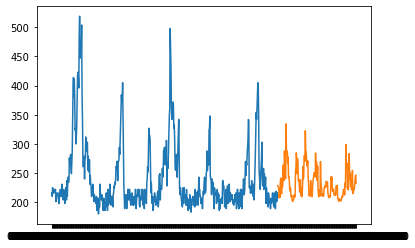

In [30]:
plt.plot(df['date'], df['electricity_consumption'], label='actual')
plt.plot(outputDf['date'], outputDf['electricity_consumption'], label='forecast')
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


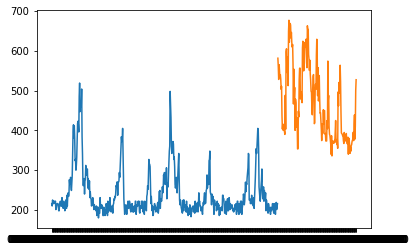

In [52]:
plt.plot(df['date'], df['electricity_consumption'], label='actual')
plt.plot(outputDf['date'], outputDf['electricity_consumption'], label='forecast')
plt.show()

In [ ]:
df2 = pd.Series(df['value'])